## Sanjay Santokee - sanjay.santokee@my.uwi.edu


In [1]:
%load_ext autoreload
%autoreload 2

***

#### Experimental Pipeline

- Data Loading
    
    Begin by loading in the concrete data set, which would be provided in a Numpy data file. 

- Data Pre-processing
    
    The concrete data set should then be divided into inputs and target data sets. The set of inputs, $x_i$, (independent variables) are to be extrapolated from the concrete data set and set to its own data set, `x`. In this case, the inputs are  the columns: Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate and Age. 

    Then the output, $y$, (dependant variable) in this case being the column: Concrete compressive strength would be set into its own data set, `y`.

- As all of the data types being quantitative, encoding is not to be done.

- Setting up K-Fold Cross-Validation. 

    Cross-validation is used since the amount of data for concrete samples provided was not a large amount. 
    
    With K-Fold, both the input and target data would be shuffled and then split into $k$ groups, in this case $k$ would be set to five. 
    
    A for-loop is done on the folds. Groups are generated on each fold.
    
    Each group would be selected as a test set on each fold (iteration) and the other groups would be used as training data. This means that each group is provided with the chance to be tested, improving the estimate on the machine learning model for unseen data to become more generalized. 

- Scaling the Data with StandardScaler

    On any fold (iteration) when a group is selected as testing data and the rest of groups are training data, only the input training set of values (`X_train`) are used to fit a StandardScaler. After fitting, the StandardScaler would then be used to transform both the input training set (`X_train`) and the input testing set (`X_test`). This is performed on every fold and is done so that the variance of the input features are in the same range. The targets (`y_train` and `y_test`) are not to be scaled.

- Fitting The Machine Learning Models

    After scaling the input data, two machine learning models, Model A & Model B are to be instantiated and then fitted with the input training data (`X_train`) and the target training data (`y_train`). Both models would then utilize the input testing set (`X_test`) in order to produce predictions, which are the possible target values, based on the data it was just trained on. 

- Evaluating Model Performance

    After producing predictions, it is then used together with the input testing set (`X_test`) in order to calculate the values for the various performance metrics. These would include the Root Mean Squared Error, Mean Absolute Error, Mean Absolute Percentage Error and $r^2$ metrics. On each fold, a value for each metric is calculated and added to an array. The mean of each of these arrays would then be able to produce the overall metric values. After all fitting of models, a t-test would then be done on both models in order to statistically determine whether or not there is a significant differrence between the performance of Model A and Model B.

- Lastly, the various metric results would then need to be examined in order to determine which model outperforms the other. 
    1. RMSE - the lower value is the better
    2. MAE - the lower value is the better
    3. MAPE - the lower value is the better
    4. $r^2$ - the higher value is the better, it will always be less than or equal to 1.

***
### (d)

#### Importing Necessary Libraries

In [2]:
%pylab inline
import numpy as np
import pandas as pd
import sklearn.model_selection as selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import torch as th
import torch.nn as nn
import torch.optim as optim
import scipy.stats as stats
import matplotlib.pyplot as plt 

Populating the interactive namespace from numpy and matplotlib


#### Loading Numpy Data

In [3]:
concrete_df = np.load('concrete.npy')

#### Splitting data into inputs and target

input ← Columns 0 to 7  
target ← Column 8

In [4]:
df = np.hsplit(concrete_df, [8])

In [5]:
x = df[0]
y = df[1]

In [6]:
np.std(y)

16.697630409134263

#### Setting up Models for Neural Network

In [7]:
class NetworkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = nn.MSELoss()
        
    def forward(self, x):
        return None 
    
    def loss(self, x, y):
        probs = self.forward(x)
        return self.loss_func(probs, y)
    
    def predict_proba(self, x, as_numpy=False):
        res = self.forward(x)
        if as_numpy:
            res = res.detach().numpy()
        return res
    
    def predict(self, x, threshold=0.5, as_numpy=False):
        probs = self.predict_proba(x, as_numpy)
        return probs
    
    def fit(self, x, y, lr, lam, epochs=800):
        optimizer = optim.RMSprop(self.parameters(), lr=lr)
        loss_curve = []
        for _ in range(epochs):
            optimizer.zero_grad()
            loss_val = self.loss(x, y) + self.regularize(lam)
            loss_curve.append(loss_val.data.item())
            loss_val.backward()
            optimizer.step()
        return loss_curve
    
    def regularize(self, lam):
        loss_val = 0
        for p in self.parameters():
            loss_val += lam * th.norm(p)
        return loss_val

In [8]:
class NNModel(NetworkModel):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(8, 16, bias=True)
        self.act1 = nn.ELU()         # ELU activation function
        self.l2 = nn.Linear(16, 8, bias=True)
        self.act2 = nn.GELU()       # Gaussian Error Linear Units activation function
        self.l3 = nn.Linear(8, 1, bias=True)
        
    def get_intermediary(self, x):
        res = self.l1(x)
        res = self.act1(res)
        return res
        
    def forward(self, x):
        res = self.l1(x)
        res = self.act1(res)
        res = self.l2(res)
        res = self.act2(res)
        res = self.l3(res)
        return res    
    

#### Function to Calculate MAPE

In [9]:
def mape(actual, predicted, eps=0.00001):
    if th.is_tensor(actual):
        actual = actual.numpy()
        
    diff = np.abs(actual - predicted)
    factor = (diff / (actual + eps)) * 100
    return np.mean(factor)

#### Function to Plot Loss Curve

In [10]:
def plot_loss(loss_curve):
    plt.plot(list(range(len(loss_curve))), loss_curve)

#### Setting up KFold

In [11]:
kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(x)

5

#### Lists to store models' performances

In [12]:
mse_lr = []
mae_lr = []
mape_lr = []
r2_lr = []

mse_nn = [] 
mae_nn = []
mape_nn =[]
r2_nn = []

#### Fitting Neural Network Model and Linear Regression Model

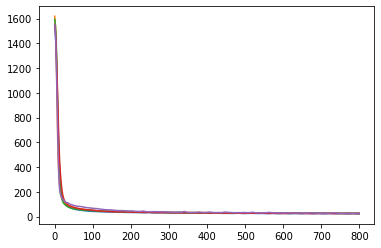

In [13]:
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Linear Regression
    linear_reg = LinearRegression()
    linear_reg.fit(X_train, y_train)
    
    predictions = linear_reg.predict(X_test)
    mse_lr.append(np.sqrt(mean_squared_error(y_test, predictions)))    # Calculating MSE
    mae_lr.append(mean_absolute_error(y_test, predictions))    # Calculating MAE
    mape_lr.append(mape(y_test, predictions))    # Calculating MAPE
    r2_lr.append(r2_score(y_test, predictions))    # Calculating r^2
    
    X_train = th.tensor(X_train, dtype=th.float32)
    X_test = th.tensor(X_test, dtype=th.float32)
    y_train = th.tensor(y_train, dtype=th.float32).view(-1, 1)
    y_test = th.tensor(y_test, dtype=th.float32).view(-1, 1)
    
    # Neural Network
    neural_net = NNModel()
    curve = neural_net.fit(X_train, y_train, lr=0.008, lam=0)
    plot_loss(curve)
    
    predictions = neural_net.predict(X_test, as_numpy=True)
    mse_nn.append(np.sqrt(mean_squared_error(y_test, predictions)))    # Calculating MSE
    mae_nn.append(mean_absolute_error(y_test, predictions))    # Calculating MAE
    mape_nn.append(mape(y_test, predictions))    # Calculating MAPE
    r2_nn.append(r2_score(y_test, predictions))    # Calculating r^2

#### Evaluating The Models Performances

#### Neural Network

In [ ]:
print('Neural Network Model - Root Mean Squared Error: ', np.mean(mse_nn))
print('Neural Network Model - Mean Absolute Error: ', np.mean(mae_nn))
print('Neural Network Model - Mean Absolute Percentage Error: ', np.mean(mape_nn))
print('Neural Network Model - R2 Score: ', np.mean(r2_nn))

#### Linear Regression

In [ ]:
print('Linear Regression Model - Root Mean Squared Error: ', np.mean(mse_lr))
print('Linear Regression Model - Mean Absolute Error: ', np.mean(mae_lr))
print('Linear Regression Model - Mean Absolute Percentage Error: ', np.mean(mape_lr))
print('Linear Regression Model - R2 Score: ', np.mean(r2_lr))

#### RMSE-  Root Mean Squared Error

The RMSE in the Linear Regression was 10.559011580397783 whereas in the Neural Network Model it was 5.6172895, so the Neural Network Model performed better by a significant amount.

In [ ]:
print('Smallest Concrete compressive strength:', np.min(y), 'MPa')
print('Largest Concrete compressive strength:', np.max(y), 'MPa')

With the smallest Concrete compressive strength (MPa) being 2.33 MPa and the largest being 82.6 MPa, it is evident that the RMSE gained from both models were not too large, this is good since the errors were small.

#### MAE- Mean Absolute Error

The Neural Network produced an MAE of 4.225154 whereas the Liner Regression Model produced an MAE 8.34601610130321, this means that here again the Neural Network Model performs better.

#### MAPE- Mean Absolute Percentage Error

The Neural Network produced a MAPE score of 13.897741 whereas the Liner Regression Model produced a MAPE 31.76189954592531, with the MAPE metric the Neural Network Model performs better.

#### $r^2$ Error

The Neural Network produced an $r^2$ score of 0.8833942222350621 (88%) whereas the Liner Regression Model produced an $r^2$  score of 0.5937634733982854 (59%). So, the Neural Network Model performs better than the Linear Regression Model.

#### T-test

In [ ]:
print('T-test comparing Linear Regression Model and the Neural Network Model: \n')
print('\t', stats.ttest_rel(mse_lr, mse_nn))

Using a significance level of 0.05, we see that theres is a statistically significant differrence between the performance of linear regression and the neural network 

#### Selecting a Model for Production

Based on the evaluation of the models performances, it can be seen that the Neural Network Model performed the best and should be the model that is put into production to evaluate unseen instances.

***

#### References

PyTorch. 2019. PyTorch Documentation. https://pytorch.org/docs/stable/.



***

#### References

PyTorch. 2019. PyTorch Documentation. https://pytorch.org/docs/stable/.



#### Neural Network

In [14]:
print('Neural Network Model - Root Mean Squared Error: ', np.mean(mse_nn))
print('Neural Network Model - Mean Absolute Error: ', np.mean(mae_nn))
print('Neural Network Model - Mean Absolute Percentage Error: ', np.mean(mape_nn))
print('Neural Network Model - R2 Score: ', np.mean(r2_nn))

Neural Network Model - Root Mean Squared Error:  5.6172895
Neural Network Model - Mean Absolute Error:  4.225154
Neural Network Model - Mean Absolute Percentage Error:  13.897741
Neural Network Model - R2 Score:  0.8833942222350621


#### Linear Regression

In [15]:
print('Linear Regression Model - Root Mean Squared Error: ', np.mean(mse_lr))
print('Linear Regression Model - Mean Absolute Error: ', np.mean(mae_lr))
print('Linear Regression Model - Mean Absolute Percentage Error: ', np.mean(mape_lr))
print('Linear Regression Model - R2 Score: ', np.mean(r2_lr))

Linear Regression Model - Root Mean Squared Error:  10.559011580397783
Linear Regression Model - Mean Absolute Error:  8.34601610130321
Linear Regression Model - Mean Absolute Percentage Error:  31.76189954592531
Linear Regression Model - R2 Score:  0.5937634733982854


#### RMSE-  Root Mean Squared Error

The RMSE in the Linear Regression was 10.559011580397783 whereas in the Neural Network Model it was 5.6172895, so the Neural Network Model performed better by a significant amount.

In [16]:
print('Smallest Concrete compressive strength:', np.min(y), 'MPa')
print('Largest Concrete compressive strength:', np.max(y), 'MPa')

Smallest Concrete compressive strength: 2.33 MPa
Largest Concrete compressive strength: 82.6 MPa


With the smallest Concrete compressive strength (MPa) being 2.33 MPa and the largest being 82.6 MPa, it is evident that the RMSE gained from both models were not too large, this is good since the errors were small.

#### MAE- Mean Absolute Error

The Neural Network produced an MAE of 4.225154 whereas the Liner Regression Model produced an MAE 8.34601610130321, this means that here again the Neural Network Model performs better.

#### MAPE- Mean Absolute Percentage Error

The Neural Network produced a MAPE score of 13.897741 whereas the Liner Regression Model produced a MAPE 31.76189954592531, with the MAPE metric the Neural Network Model performs better.

#### $r^2$ Error

The Neural Network produced an $r^2$ score of 0.8833942222350621 (88%) whereas the Liner Regression Model produced an $r^2$  score of 0.5937634733982854 (59%). So, the Neural Network Model performs better than the Linear Regression Model.

#### T-test

In [17]:
print('T-test comparing Linear Regression Model and the Neural Network Model: \n')
print('\t', stats.ttest_rel(mse_lr, mse_nn))

T-test comparing Linear Regression Model and the Neural Network Model: 

	 Ttest_relResult(statistic=20.76558577435423, pvalue=3.177531084067026e-05)


Using a significance level of 0.05, we see that theres is a statistically significant differrence between the performance of linear regression and the neural network 

#### Selecting a Model for Production

Based on the evaluation of the models performances, it can be seen that the Neural Network Model performed the best and should be the model that is put into production to evaluate unseen instances.

***

#### References

PyTorch. 2019. PyTorch Documentation. https://pytorch.org/docs/stable/.

